In this notebook, I'm going to use different algorithms to complete a binary classification task in *Machine Learning in Practice* course.

I aim to solve the problem statement by creating a plan of action, Here are some of the necessary steps:

1. Data Exploration
2. Exploratory Data Analysis (EDA)
3. Data Pre-processing
4. Predictive Modelling
5. Predict on Test Set

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# <center>1. Data Exploration
### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

### Load Data From CSV File  

In [2]:
df = pd.read_csv('./loan/train.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [3]:
# remove irrelevant column & rename row & process date feature

df['Num of days'] = (pd.to_datetime(df['due_date']) - pd.to_datetime(df['effective_date'])).dt.days
df.columns = [col.capitalize() for col in df.columns]
df.drop(['Unnamed: 0.1', "Unnamed: 0", "Effective_date", "Due_date"], inplace=True, axis=1)
df.head()

,Loan_status,Principal,Terms,Age,Education,Gender,Num of days
0,PAIDOFF,1000,30,45,High School or Below,male,29
1,PAIDOFF,1000,30,33,Bechalor,female,29
2,PAIDOFF,1000,15,27,college,male,14
3,PAIDOFF,1000,30,28,college,female,29
4,PAIDOFF,1000,30,29,college,male,29


In [4]:
# Checking number of unique rows in each feature
target = 'Loan_status'
features = [attr for attr in df.columns if attr != target]
category_features = ['Education', 'Gender']
numeric_features = [attr for attr in features if not attr in category_features]
df[features].nunique().sort_values()


Gender          2
Terms           3
Education       4
Principal       5
Num of days     6
Age            32
dtype: int64

# <center> 2. Exploratory Data Analysis (EDA)

                           Visualising Categorical Features & Target:                           


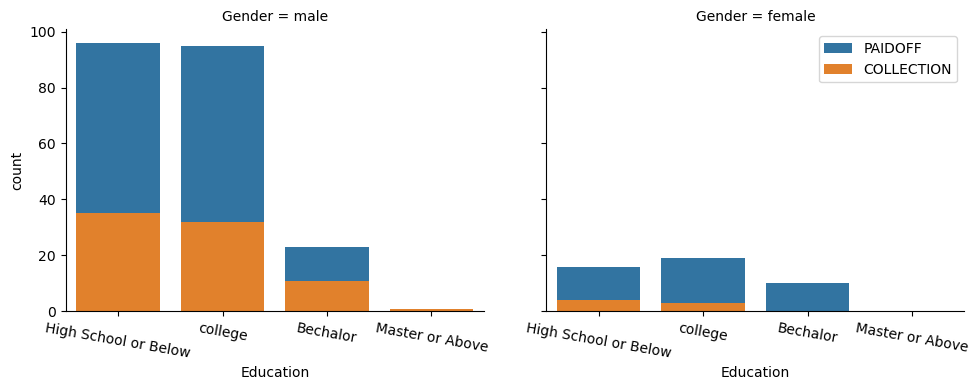

In [5]:
print('\033[1mVisualising Categorical Features & Target:'.center(100))

g = sns.FacetGrid(df, col="Gender", hue="Loan_status",  col_wrap=2, sharex=True)
g.map(sns.countplot, 'Education', order=df['Education'].value_counts().index)
g.axes[-1].legend()
g.set_xticklabels(rotation=-10)
g.fig.set_size_inches(10, 4)
plt.tight_layout()
plt.show()

                                 Numeric Features Distribution                                  


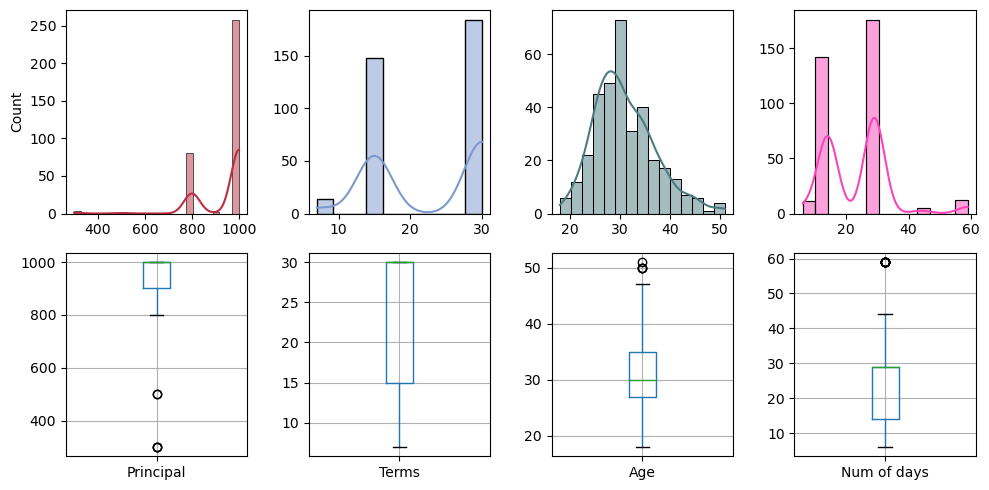

In [6]:
#Visualising the numeric features 

print('\033[1mNumeric Features Distribution'.center(100))

fig, axs = plt.subplots(2, 4, figsize=(10, 5))
for i in range(len(numeric_features)):
    sns.histplot(df[numeric_features[i]], kde=True, color=list(np.random.rand(3)), ax=axs[0, i])
    df.boxplot(numeric_features[i], ax=axs[1, i])
    axs[0, i].set_xlabel("")
    axs[0, i].set_ylabel("")
axs[0, 0].set_ylabel('Count')
plt.tight_layout()
plt.show()

# <center> 3. Data Pre-processing

### \[OPTIONAL\] Deal with class imbalance

**This module is only enabled when using SMOTE-NE to over-sample minority categories**

In [7]:
%pip install -U --quiet imbalanced-learn

from imblearn.over_sampling import SMOTENC
sampler = SMOTENC(category_features, random_state=42)
def over_sample(df):
    X, y = df.drop([target], axis=1), df[target]
    new_X, new_y = sampler.fit_resample(X, y)
    print(f"Shape before resample: {df.shape}")
    new_df = pd.concat([new_y, new_X], axis=1)
    print(f"Shape after resample: {new_df.shape}")
    return new_df


Note: you may need to restart the kernel to use updated packages.


### Convert Categorical features to numerical values

Lets convert `Gender` to binary value, that is, male to 0 and female to 1.

Then, use one-hot encoding to convert `Education`. Note that the category value `Master or Above` of `Education` is extreamly rare in samples, so just remove it.


In [19]:
def cvt_one_hot(df: pd.DataFrame):
    new_df = pd.concat(
        [df.drop(["Education"], axis=1), pd.get_dummies(df["Education"])], axis=1
    )
    new_df["Gender"].replace(to_replace=["male", "female"], value=[0, 1], inplace=True)
    if target in new_df.columns:
        new_df[target].replace(
            to_replace=["COLLECTION", "PAIDOFF"], value=[0, 1], inplace=True
        )
    return new_df.drop(["Master or Above"], axis=1)

### \[OPTIONAL\] Deal with Outliner
**This module is only enabled when using quartile to remove outliner**

In [9]:
def remove_outliner(df):
    new_df = df.copy()
    print(f"Shape before removal: {df.shape}")
    for i in numeric_features:
        Q1 = new_df[i].quantile(0.25)
        Q3 = new_df[i].quantile(0.75)
        IQR = Q3 - Q1
        new_df = new_df[new_df[i] <= (Q3 + (1.5 * IQR))]
        new_df = new_df[new_df[i] >= (Q1 - (1.5 * IQR))]
        new_df = new_df.reset_index(drop=True)

    print(f"Shape after removal: {new_df.shape}")
    return new_df

### Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [10]:
def normalize(df, excluded_columns=[target]):
    scaler = preprocessing.StandardScaler()
    if isinstance(df, pd.DataFrame):
        X = df.drop(excluded_columns, axis=1)
        return pd.concat([df[excluded_columns], pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=df.index)], axis=1)
    return scaler.fit_transform(df)

# <center> 4. Predictive Modelling

In this section, I will implement the following algorithms:
- CatBoost
- Support Vector Machine
- Logistic Regression

The experiment settings are as follows:
1. SMOTE-NC vs without SMOTE-NC for each algorithms
2. CatBoost vs Support Vector Machine vs Logistic Regression




In [11]:
# define necessary methods
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    balanced_accuracy_score
)


def evaluate(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Macro F1 Score: {f1:.2f}")
    print(f"Balanced Accuracy Score: {balanced_accuracy:.2f}")


def run_algorithm(classifier, over_sampled=False, one_hot=True):
    my_df = over_sample(df) if over_sampled else remove_outliner(df)
    if one_hot:
        my_df = cvt_one_hot(my_df)
    X = my_df.drop([target], axis=1)
    y = my_df[target]
    train_X, test_X, train_y, test_y = train_test_split(
        X, y, train_size=0.8, test_size=0.2, random_state=100
    )
    if one_hot:
        train_X, test_X, train_y, test_y = (
            normalize(train_X.values),
            normalize(test_X.values),
            train_y.values, 
            test_y.values,
        )
    else:
        train_X, test_X = normalize(train_X, category_features), normalize(test_X, category_features)
        train_y.replace(to_replace=['COLLECTION', 'PAIDOFF'], value=[0, 1], inplace=True)
        test_y.replace(to_replace=['COLLECTION', 'PAIDOFF'], value=[0, 1], inplace=True)
    
    classifier.fit(train_X, train_y)
    y_pred = classifier.predict(test_X)
    evaluate(test_y, y_pred)

### Logistic Regression
First of all, we should do extra feature selection before using linear regression

In [12]:
%pip install --quiet statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
one_hot_df = normalize(cvt_one_hot(remove_outliner(df)))
vif = pd.DataFrame()
X = one_hot_df.drop([target], axis=1)
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif.reset_index(drop=True, inplace=True)
vif

Note: you may need to restart the kernel to use updated packages.
Shape before removal: (346, 7)
Shape after removal: (325, 7)


,Features,VIF
0,Bechalor,inf
1,High School or Below,inf
2,Master or Above,inf
3,college,inf
4,Education,inf
5,Num of days,4.42
6,Terms,4.31
7,Principal,1.43
8,Age,1.05
9,Gender,1.02


In [20]:
from sklearn.linear_model import LogisticRegression
print("normal")
run_algorithm(LogisticRegression(random_state=42))
print("SMOTE-NC")
run_algorithm(LogisticRegression(random_state=42), over_sampled=True)
print("class balanced")
run_algorithm(LogisticRegression(class_weight='balanced', random_state=42))


normal
Shape before removal: (346, 7)
Shape after removal: (325, 7)
Accuracy: 0.77
Macro F1 Score: 0.43
Balanced Accuracy Score: 0.50
SMOTE-NC
Shape before resample: (346, 7)
Shape after resample: (520, 7)
Accuracy: 0.57
Macro F1 Score: 0.56
Balanced Accuracy Score: 0.58
class balanced
Shape before removal: (346, 7)
Shape after removal: (325, 7)
Accuracy: 0.51
Macro F1 Score: 0.49
Balanced Accuracy Score: 0.59


# Support Vector Machine

In [21]:
from sklearn import svm
print("normal")
run_algorithm(svm.SVC(random_state=42, kernel='rbf'))
print("SMOTE-NC")
run_algorithm(svm.SVC(random_state=42, kernel='rbf'), over_sampled=True)
print("class balanced")
run_algorithm(svm.SVC(random_state=42, kernel='rbf', class_weight='balanced'))

normal
Shape before removal: (346, 7)
Shape after removal: (325, 7)
Accuracy: 0.77
Macro F1 Score: 0.43
Balanced Accuracy Score: 0.50
SMOTE-NC
Shape before resample: (346, 7)
Shape after resample: (520, 7)
Accuracy: 0.67
Macro F1 Score: 0.67
Balanced Accuracy Score: 0.69
class balanced
Shape before removal: (346, 7)
Shape after removal: (325, 7)
Accuracy: 0.52
Macro F1 Score: 0.50
Balanced Accuracy Score: 0.57


### CatBoost

In [15]:
%pip install -U --quiet catboost
from catboost import CatBoostClassifier
print("normal")
run_algorithm(CatBoostClassifier(iterations=300,  cat_features=category_features, verbose=0, random_seed=42), one_hot=False)
print("SMOTE-NC")
run_algorithm(CatBoostClassifier(iterations=300, cat_features=category_features, verbose=0, random_seed=42), one_hot=False, over_sampled=True)
print("class balanced")
run_algorithm(CatBoostClassifier(iterations=300, auto_class_weights='Balanced', cat_features=category_features, verbose=0, random_seed=42), one_hot=False)

Note: you may need to restart the kernel to use updated packages.
normal
Shape before removal: (346, 7)
Shape after removal: (325, 7)
Accuracy: 0.77
Macro F1 Score: 0.43
Balanced Accuracy Score: 0.50
SMOTE-NC
Shape before resample: (346, 7)
Shape after resample: (520, 7)
Accuracy: 0.66
Macro F1 Score: 0.66
Balanced Accuracy Score: 0.67
class balanced
Shape before removal: (346, 7)
Shape after removal: (325, 7)
Accuracy: 0.63
Macro F1 Score: 0.59
Balanced Accuracy Score: 0.64


# <center> 5. Predict on Test Set
### Load data & preprocess & Train



In [22]:
test_df = pd.read_csv("./loan/test.csv")
test_df["Num of days"] = (
    pd.to_datetime(test_df["due_date"]) - pd.to_datetime(test_df["effective_date"])
).dt.days
test_df.columns = [col.capitalize() for col in test_df.columns]
test_df.drop(
    ["Unnamed: 0.1", "Unnamed: 0", "Effective_date", "Due_date"], inplace=True, axis=1
)
test_X = normalize(cvt_one_hot(test_df).values)

train_df = cvt_one_hot(over_sample(df))
train_X, train_y = normalize(train_df.drop([target], axis=1).values), train_df[target]
print(train_df.head(), "\n\n", test_df.head())
classifer = svm.SVC(random_state=42, kernel='rbf')
classifer.fit(train_X, train_y)

Shape before resample: (346, 7)
Shape after resample: (520, 7)
   Loan_status  Principal  Terms  Age  Education  Gender  Num of days
0            1       1000     30   45          1       0           29
1            1       1000     30   33          0       1           29
2            1       1000     15   27          3       0           14
3            1       1000     30   28          3       1           29
4            1       1000     30   29          3       0           29 

    Principal  Terms  Age             Education  Gender  Num of days
0       1000     30   50              Bechalor  female           29
1        300      7   35       Master or Above    male            6
2       1000     30   43  High School or Below  female           29
3       1000     30   26               college    male           29
4        800     15   29              Bechalor    male           14


SVC(random_state=42)

In [17]:
with open('58121102.txt', 'w') as file:
    file.writelines(['PAIDOFF\n' if y else 'COLLECTION\n' for y in classifer.predict(test_X)])